In [1]:
import json
from pathlib import Path
import spacy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"

In [3]:
def load_clean_book(filename: str) -> dict:
    path = PROCESSED_DIR / filename
    with open(path, encoding = "utf-8") as f:
        data = json.load(f)
    return data

cap = load_clean_book("crime_and_punishment_clean.json")
ge = load_clean_book("great_expectations_clean.json")
cmc = load_clean_book("the_count_of_monte_christo_clean.json")

cap.keys(), len(cap['chapters']), cap['chapters'][0][0]

(dict_keys(['book', 'chapters']), 39, 'CHAPTER I')

In [4]:
def full_text_from_chapters(book_data: dict) -> str:
    texts = [ch[1] for ch in book_data["chapters"]]
    return "\n\n".join(texts)

cap_text = full_text_from_chapters(cap)
ge_text = full_text_from_chapters(ge)
cmc_text = full_text_from_chapters(cmc)

len(cap_text), cap_text[:500]

(1129971,
 'On an exceptionally hot evening early in July a young man came out of\nthe garret in which he lodged in S. Place and walked slowly, as though\nin hesitation, towards K. bridge.\n\nHe had successfully avoided meeting his landlady on the staircase. His\ngarret was under the roof of a high, five-storied house and was more\nlike a cupboard than a room. The landlady who provided him with garret,\ndinners, and attendance, lived on the floor below, and every time\nhe went out he was obliged to pass her kitchen')

In [5]:
nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner", "tagger"])
nlp.max_length = 3_000_000
nlp.add_pipe("sentencizer")

In [6]:
def compute_style_metrics(full_text: str, nlp) -> dict:
    doc = nlp(full_text)

    tokens = [t.text.lower() for t in doc if t.is_alpha]
    num_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    ttr = num_unique_tokens / num_tokens

    sentence_lenghts = [len([t for t in sent if t.is_alpha]) for sent in doc.sents]

    avg_sentence_length = sum(sentence_lenghts) / len(sentence_lenghts)

    return {
        "num_tokens": num_tokens,
        "num_unique_tokens": num_unique_tokens,
        "type_token_ratio": ttr,
        "avg_sentence_length": avg_sentence_length,
    }

In [7]:
books = {
    "Crime and Punishment": cap_text,
    "Great Expectations": ge_text,
    "The Count of Monte Christo": cmc_text,
}

metrics_list = []

for book_name, text in books.items():
    m = compute_style_metrics(text, nlp)
    m["book"] = book_name
    metrics_list.append(m)


c:\Users\ThinkPad T450\.conda\envs\literary\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
df_metrics = pd.DataFrame(metrics_list).set_index("book")

In [9]:
df_metrics

,num_tokens,num_unique_tokens,type_token_ratio,avg_sentence_length
book,,,,
Crime and Punishment,203841,9300,0.045624,14.247641
Great Expectations,183977,10590,0.057562,19.011781
The Count of Monte Christo,460447,15686,0.034067,17.573642


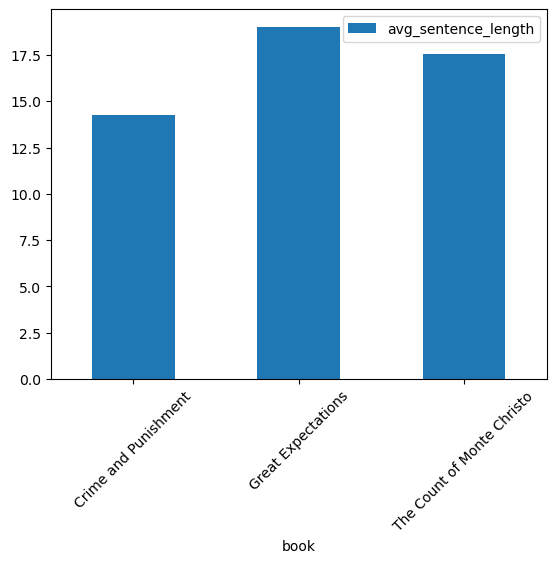

In [17]:
df_metrics[["avg_sentence_length"]].plot(kind="bar", rot=45)

plt.savefig(BASE_DIR / "plots" / "sentence_lenght_comparison.png", dpi = 300, bbox_inches='tight')
plt.show()

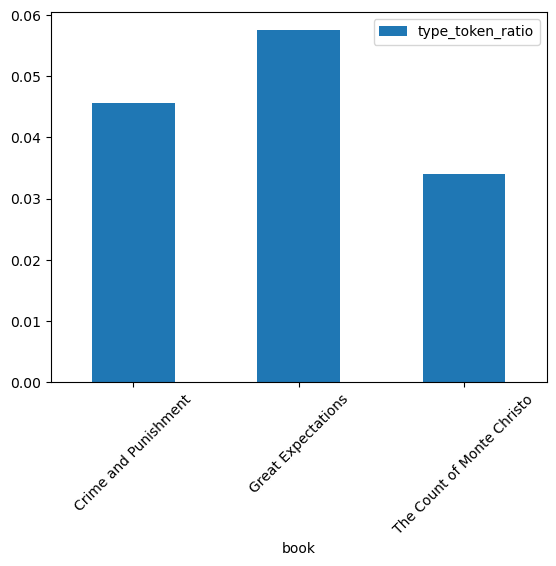

In [18]:
df_metrics[["type_token_ratio"]].plot(kind="bar", rot=45)

plt.savefig(BASE_DIR / "plots" / "ttr_comparison.png", dpi = 300, bbox_inches='tight')
plt.show()